In [3]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# from ercollect import molecule as mol
# from ercollect.molecule import molecule
from ercollect.rxn_syst import reaction, get_RS, yield_rxn_syst
import matplotlib.pyplot as plt
import numpy as np
import sys
from rdkit.Chem import Fragments, Descriptors
# import random
# import os
# import requests
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
# from IPython.display import clear_output
# from ercollect import SABIO_IO

Author: Andrew Tarzia

Date Created: 11 Dec 2018

Distributed under the terms of the MIT License.

# Notebook to analyse reaction systems for the SALE-ZIF-8 case study

## Step 1:
- Find reaction systems with maximum component sizes within some range
    - lower threshold $\leq d \leq$ upper threshold

In [49]:
threshold = (5, 7)

In [50]:
directory = '/home/atarzia/psp/screening_results/'
directory += 'kegg_111218/'
# directory += 'new_reactions_atlas_111218/'
# directory += 'new_reactions_kegg_atlas/'
# directory += 'new_reactions_sabio_wcharge/'
# directory += 'biomin_search_sabio_wcharge/'

In [51]:
target_RS = []
out_range = []
in_range = []
for i, rs in enumerate(yield_rxn_syst(output_dir=directory)):
    if rs.skip_rxn is True:
        continue
    if rs.max_comp_size is None:
        continue
    if rs.max_comp_size >= threshold[0] and rs.max_comp_size <= threshold[1]:
        target_RS.append(rs.pkl)
        in_range.append(rs.max_comp_size)
    else:
        out_range.append(rs.max_comp_size)    

1233 reactions in threshold


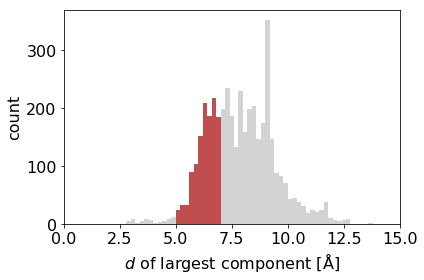

In [52]:
print(len(target_RS), 'reactions in threshold')
fig, ax = plt.subplots()
ax.hist(in_range, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(0, 20, 0.2))
ax.hist(out_range, 
        facecolor='lightgray',  # '#FF7900', 
        histtype='stepfilled', bins=np.arange(0, 20, 0.2))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('$d$ of largest component [$\mathrm{\AA}$]', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 15)
fig.tight_layout()
fig.savefig(directory+"CS_maxd.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 2:
- From the target RS:
    - Search for reactions that show a gain or loss of a UV/Vis or IR active component
    - searching for:
        - terminal acetylenes: rdkit.Chem.Fragments.fr_term_acetylene -- did not include this search (19/12/18)
        - nitriles: rdkit.Chem.Fragments.fr_nitrile

In [53]:
def has_terminal_acetylene(SMILES):
    """Returns False if terminal acetylene fragment is not found using RDKIT.

    """
    mol = Chem.MolFromSmiles(SMILES)
    no_frag = Fragments.fr_term_acetylene(mol)
    if no_frag > 0:
        return True
    else:
        return False
    

def has_nitrile(SMILES):
    """Returns False if terminal acetylene fragment is not found using RDKIT.

    """
    mol = Chem.MolFromSmiles(SMILES)
    no_frag = Fragments.fr_nitrile(mol)
    if no_frag > 0:
        return True
    else:
        return False

In [58]:
target_RS_2 = []
has_acet = 0
has_nit = 0
for pkl in target_RS:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    r_acet = 0
    r_nit = 0
    p_acet = 0
    p_nit = 0
    for m in rs.components:
        acet = has_terminal_acetylene(m.SMILES)
        nit = has_nitrile(m.SMILES)
        if m.role == 'reactant':
            if acet is True:
                r_acet += 1
            if nit is True:
                r_nit += 1
        elif m.role == 'product':
            if acet is True:
                p_acet += 1
            if nit is True:
                p_nit += 1
    if r_acet > 0 or p_acet > 0 or r_nit > 0 or p_nit >0:
        print('------------------------------------------------------')
        print(r_acet, p_acet, r_nit, p_nit)
#         if p_acet == 0 and r_acet > 0:
#             target_RS_2.append(rs.pkl)
#             has_acet += 1
#             print('1')
#             print(rs.pkl)
#         elif r_acet == 0 and p_acet > 0:
#             target_RS_2.append(rs.pkl)
#             has_acet += 1
#             print('2')
#             print(rs.pkl)
#         if p_nit == 0 and r_nit > 0:
#             target_RS_2.append(rs.pkl)
#             has_nit += 1
#             print('3')
#             print(rs.pkl)
#         elif r_nit == 0 and p_nit > 0:
#             target_RS_2.append(rs.pkl)
#             has_nit += 1
#             print('4')
#             print(rs.pkl)
        if p_nit > 0 or r_nit > 0:
            target_RS_2.append(rs.pkl)
            has_nit += 1
            print('5')
            print(rs.pkl)

------------------------------------------------------
0 0 0 1
5
sRS-1_14_14_37-KEGG-R04306.gpkl
------------------------------------------------------
0 0 0 1
5
sRS-1_14_14_41-KEGG-R11639.gpkl
------------------------------------------------------
0 0 0 1
5
sRS-1_14_14_41-KEGG-R11641.gpkl
------------------------------------------------------
0 0 0 1
5
sRS-1_14_14_44-KEGG-R07638.gpkl
------------------------------------------------------
0 0 1 1
5
sRS-1_1_3_49-KEGG-R11380.gpkl
------------------------------------------------------
0 0 1 1
5
sRS-2_3_2_2-KEGG-R03971.gpkl
------------------------------------------------------
0 0 0 1
5
sRS-2_8_1_1-KEGG-R01931.gpkl
------------------------------------------------------
0 0 1 0
5
sRS-3_5_5_1-KEGG-R01887.gpkl
------------------------------------------------------
0 0 1 0
5
sRS-3_5_5_1-KEGG-R03542.gpkl
------------------------------------------------------
0 0 1 0
5
sRS-3_5_5_1-KEGG-R05591.gpkl
-----------------------------------------------

33 reactions in threshold


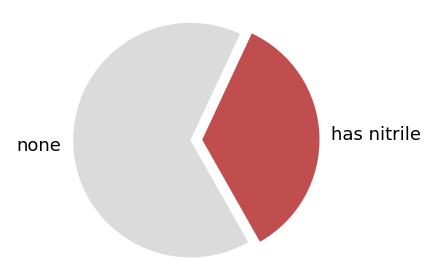

In [59]:
print(len(target_RS_2), 'reactions in threshold')
fig, ax = plt.subplots()    
# Data to plot
labels = 'none', 'has nitrile'
sizes = [len(target_RS), has_nit*20]
colors = ['lightgray', 'firebrick']
explode = (0, 0.1)  # explode 1st slice
 
# Plot
patches, texts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                        shadow=False, startangle=65)
for i in texts:
    i.set_fontsize(18)
for i in patches:
    i.set_alpha(0.8)
ax.axis('equal')
fig.tight_layout()
fig.savefig(directory+"CS_pie.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 3:
- Plot the maximum logP vs. maximum logS of the remaining reactions

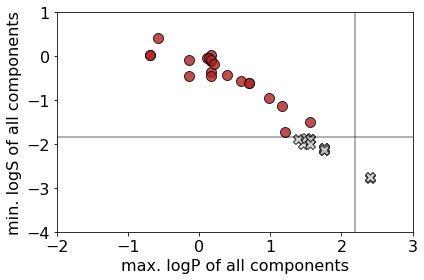

In [60]:
Y_cut = -1.84  # logS of pentane
X_cut = 2.1965  # logP of pentane
fig, ax = plt.subplots()
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    if rs.min_logS > Y_cut and rs.max_logP < X_cut:
        ax.scatter(rs.max_logP, rs.min_logS, c='firebrick', alpha=0.8, s=100, edgecolor='k')
    else:
        ax.scatter(rs.max_logP, rs.min_logS, c='lightgray', alpha=0.8, s=100, marker='X', edgecolor='k')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('max. logP of all components', fontsize=16)
ax.set_ylabel('min. logS of all components', fontsize=16)
ax.axhline(y=Y_cut, c='k', alpha=0.4)
ax.axvline(x=X_cut, c='k', alpha=0.4)
ax.set_xlim(-2, 3)
ax.set_ylim(-4, 1)
fig.tight_layout()
fig.savefig(directory+"CS_solub.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()   

## Step 4:
- Print each reaction (only print reactions with fully specified EC numbers)

In [61]:
count = 0
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
#     if '-' in rs.EC:
#         continue
    if rs.min_logS < Y_cut or rs.max_logP > X_cut:
        continue
    count += 1
    print('---------------')
    print(rs.pkl)
    print('EC:', rs.EC, ' --- KEGG ID:', rs.DB_ID)
    print('min logS:', rs.min_logS, 'max logP:', rs.max_logP)
    before_str = []
    after_str = []
    for m in rs.components:
        if m.role == 'reactant':
            before_str.append(m.name)
        elif m.role == 'product':
            after_str.append(m.name)
        print(m.name, ':', Descriptors.ExactMolWt(Chem.MolFromSmiles(m.SMILES)))
        print(m.SMILES)
    print(' + '.join(before_str), '<->', ' + '.join(after_str))
    print('---------------')
print(count, 'reactions.')

---------------
sRS-1_14_14_41-KEGG-R11639.gpkl
EC: 1.14.14.41  --- KEGG ID: R11639
min logS: -1.5078224523507036 max logP: 1.55608
C20312 : 101.084063972
CC[C@H](C)/C=N\O
C21525 : 83.073499288
CCC(C)C#N
C00001 : 18.010564684
O
C20312 <-> C21525 + C00001
---------------
---------------
sRS-1_14_14_41-KEGG-R11641.gpkl
EC: 1.14.14.41  --- KEGG ID: R11641
min logS: -1.1291740273854483 max logP: 1.16598
C20315 : 87.068413908
CC(C)/C=N\O
C02420 : 69.057849224
CC(C)C#N
C00001 : 18.010564684
O
C20315 <-> C02420 + C00001
---------------
---------------
sRS-2_3_2_2-KEGG-R03971.gpkl
EC: 2.3.2.2  --- KEGG ID: R03971
min logS: -0.44850811687612063 max logP: -0.14122
C05670 : 70.053098192
N#CCCN
C00025 : 147.053157768
N[C@@H](CCC(=O)O)C(=O)O
C06114 : 199.095691276
N#CCCNC(=O)CC[C@H](N)C(=O)O
C00001 : 18.010564684
O
C05670 + C00025 <-> C06114 + C00001
---------------
---------------
sRS-2_8_1_1-KEGG-R01931.gpkl
EC: 2.8.1.1  --- KEGG ID: R01931
min logS: -0.4242758593500813 max logP: 0.39728
C00320 :

## Step 5:
- Manual collection of reaction information
    - Can we get ZINC prices?
    - Can we get directionality?

----------------------------------------------------------------------------
- sRS-1_14_14_41-KEGG-R11639.gpkl, EC: 1.14.14.41  --- KEGG ID: R11639
    - C20312 <-> C21525 + C00001 -- direction:
        - C20312 : 101.084063972
            - CC[C@H](C)/C=N\O -- http://zinc15.docking.org/substances/ZINC000013540376/
                - has prices
        - C21525 : 83.073499288
            - CCC(C)C#N -- http://zinc15.docking.org/substances/ZINC000001648961/, http://zinc15.docking.org/substances/ZINC000002017145/
                - has prices
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------
- sRS-1_14_14_41-KEGG-R11641.gpkl, EC: 1.14.14.41  --- KEGG ID: R11641
    - C20315 <-> C02420 + C00001 -- direction:
        - C20315 : 87.068413908
            - CC(C)/C=N\O -- http://zinc15.docking.org/substances/ZINC000013508087/
                - has prices
        - C02420 : 69.057849224
            - CC(C)C#N -- http://zinc15.docking.org/substances/ZINC000000901364/
                - has prices
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------
- sRS-2_8_1_1-KEGG-R01931.gpkl, EC: 2.8.1.1  --- KEGG ID: R01931 --- SKIPPED
    - C00320 + C00177 <-> C00094 + C01755 -- direction:
        - C00320 : 112.93725947191001
            - O=S(=O)(O)[S-]
        - C00177 : 26.00362257991
            - [C-]#N
        - C00094 : 81.97246492400001
            - O=S(O)O
        - C01755 : 58.982970032
            - N#CS
----------------------------------------------------------------------------
- sRS-3_5_5_1-KEGG-R01887.gpkl, EC: 3.5.5.1  --- KEGG ID: R01887
    - C05715 + C00001 <-> C00302 + C00014 -- direction: Forms glutamate (C00302)\cite{yanase1983}, which is takes an expensive chemical and makes a cheap one.
        - C05715 : 128.058577496
            - N#CC(N)CCC(=O)O -- http://zinc15.docking.org/substances/ZINC000000895866/, http://zinc15.docking.org/substances/ZINC000000895869/ 
                - has prices - make on demand
        - C00001 : 18.010564684
            - O
        - C00302 : 147.053157768
            - NC(CCC(=O)O)C(=O)O -- http://zinc15.docking.org/substances/ZINC000000895124/
                - glutamate, very easy to get
        - C00014 : 17.026549096
            - N
----------------------------------------------------------------------------
- sRS-3_5_5_1-KEGG-R03542.gpkl, EC: 3.5.5.1  --- KEGG ID: R03542
    - C05714 + C00001 <-> C01401 + C00014 -- direction: will be the same as RO1887 above. Not ideal.
        - C05714 : 70.053098192
            - CC(N)C#N -- http://zinc15.docking.org/substances/ZINC000020177345/, http://zinc15.docking.org/substances/ZINC000020177348/
                - has prices
        - C00001 : 18.010564684
            - O
        - C01401 : 89.047678464
            - CC(N)C(=O)O -- alanine. very easy to purchase
        - C00014 : 17.026549096
            - N
----------------------------------------------------------------------------
- sRS-3_5_5_4-KEGG-R00486.gpkl, EC: 3.5.5.4  --- KEGG ID: R00486
    - C02512 + C00001 <-> C00049 + C00014 -- direction: toward l_alanine (from KEGG pathway), therefore not productive.\cite{yanase1983}
        - C02512 : 114.042927432
            - N#CC[C@H](N)C(=O)O -- http://zinc15.docking.org/substances/ZINC000000901380/
                - has prices on Sigma, not cheap.
        - C00001 : 18.010564684
            - O
        - C00049 : 133.037507704
            - N[C@@H](CC(=O)O)C(=O)O -- http://zinc15.docking.org/substances/ZINC000000895032/
                - has prices, is aspartate.
        - C00014 : 17.026549096
            - N
----------------------------------------------------------------------------
- sRS-3_5_5_4-KEGG-R01267.gpkl, EC: 3.5.5.4  --- KEGG ID: R01267 -- Skip. Assuming similar to R00486
    - C00152 <-> C02512 + C00001 -- direction:
        - C00152 : 132.053492116
            - NC(=O)C[C@H](N)C(=O)O
        - C02512 : 114.042927432
            - N#CC[C@H](N)C(=O)O
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------
- sRS-3_5_5_7-KEGG-R05358.gpkl, EC: 3.5.5.7  --- KEGG ID: R05358
    - C01998 + C00001 <-> C00511 + C00014 -- direction: KEGG pathway says the cheaper molecule is product. Not productive.
        - C01998 : 53.026549096
            - C=CC#N -- http://zinc15.docking.org/substances/ZINC000000901212/
                - has prices: 38 USD per gram on MOLPORT
        - C00001 : 18.010564684
            - O
        - C00511 : 72.021129368
            - C=CC(=O)O -- http://zinc15.docking.org/substances/ZINC000000895281/
                - has prices: 21 USD per gram on MOLPORT
        - C00014 : 17.026549096
            - N
----------------------------------------------------------------------------
- sRS-4_2_1_65-KEGG-R01267.gpkl, EC: 4.2.1.65  --- KEGG ID: R01267
    - C00152 <-> C02512 + C00001 -- direction: Same as above R01267.
        - C00152 : 132.053492116
            - NC(=O)C[C@H](N)C(=O)O
        - C02512 : 114.042927432
            - N#CC[C@H](N)C(=O)O
        - C00001 : 18.010564684
           - O
----------------------------------------------------------------------------
- sRS-4_2_1_69-KEGG-R00778.gpkl, EC: 4.2.1.69  --- KEGG ID: R00778
    - C00086 <-> C01566 + C00001 -- direction: not productive. Urea to cyanamide. Both cheap.
        - C00086 : 60.032362748
            - NC(N)=O
        - C01566 : 42.021798063999995
            - N#CN
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------
- sRS-4_2_1_84-KEGG-R05379.gpkl, EC: 4.2.1.84  --- KEGG ID: R05379
    - C01659 <-> C01998 + C00001 -- direction:
        - C01659 : 71.03711378
            - C=CC(N)=O
        - C01998 : 53.026549096
            - C=CC#N
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------
- sRS-4_4_1_9-KEGG-R02846.gpkl, EC: 4.4.1.9  --- KEGG ID: R02846 - Because of the cyanide ion, RDKIT did not recognise this as containing a nitrile on both sides.
    - C00736 + C00177 <-> C00283 + C02512 -- direction: From cysteine to C02512\cite{akopyan1975}
        - C00736 : 121.019749464
            - NC(CS)C(=O)O -- http://zinc15.docking.org/substances/ZINC000000895042/
                - Cysteine. Shoudl be cheap
        - C00177 : 26.00362257991
            - [C-]#N
        - C00283 : 33.987721064
            - S
        - C02512 : 114.042927432
            - N#CC[C@H](N)C(=O)O -- http://zinc15.docking.org/substances/ZINC000000901380/
                - has prices on Sigma, not cheap.
----------------------------------------------------------------------------
- sRS-XX_XX_XX_XX-KEGG-R00917.gpkl, EC: -.-.-.-  --- KEGG ID: R00917
    - C00099 + C00014 <-> C05670 + C00001 -- direction: Substare is the nitrile based on KEGG suggestions, even though EC not specified they say its similar to EC 3.5.5.1/.4
        - C00099 : 89.047678464
            - NCCC(=O)O
        - C00014 : 17.026549096
            - N
        - C05670 : 70.053098192
            - N#CCCN
        - C00001 : 18.010564684
            - O
----------------------------------------------------------------------------

## Step 5:
- Get some properties of target reaction + draw molecules for paper

In [31]:
pkl_name = 'sRS-4_4_1_9-KEGG-R02846.gpkl'

In [32]:
rs = get_RS(directory+pkl_name, output_dir=directory, verbose=True)

loading: sRS-4_4_1_9-KEGG-R02846.gpkl


In [33]:
print(rs.delta_comp)

58.7


In [34]:
print(rs.delta_sa)

0.26391537727500225


In [36]:
print(rs.min_logS, rs.max_logP)

-0.04787119519373567 0.11280000000000001


C00736 5.74 -0.6719000000000002 -0.03490041199868123 reactant 2.9786198701131212 75.3 /home/atarzia/psp/molecule_DBs/atarzia/ATRS_115.gpkl
C00736 KEGG
--- 121.019749464
C00177 3.281 0.09637 0.017655488544460363 reactant 5.247906380487853 10 /home/atarzia/psp/molecule_DBs/atarzia/ATRS_3689.gpkl
C00177 KEGG
--- 26.00362257991
C00283 3.631 0.11280000000000001 -0.04787119519373567 product 6.963984615384615 0 /home/atarzia/psp/molecule_DBs/atarzia/ATRS_363.gpkl
C00283 KEGG
--- 33.987721064
C02512 5.92 -0.6880200000000001 0.023729556962231432 product 3.2425352473881235 134 /home/atarzia/psp/molecule_DBs/atarzia/ATRS_2734.gpkl
C02512 KEGG
--- 114.042927432


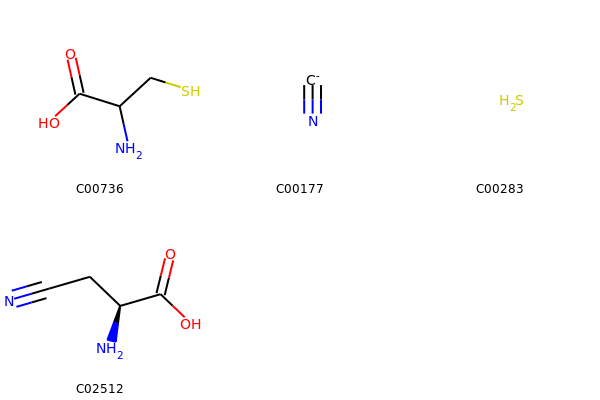

In [35]:
smiles_list = []
n_list = []
for m in rs.components:
    print(m.name, m.mid_diam, m.logP, m.logS, m.role, m.Synth_score, m.complexity, m.pkl)
    print(m.name, m.DB)
    print('---', Descriptors.ExactMolWt(Chem.MolFromSmiles(m.SMILES)))
    n_list.append(m.name)
    smiles_list.append(m.SMILES)
    MOL = Chem.MolFromSmiles(m.SMILES)
    Draw.MolToFile(MOL, fileName=m.name+'.svg')
m_list = [Chem.MolFromSmiles(i) for i in smiles_list]
Draw.MolsToGridImage(m_list, legends=n_list)

# Done

## Step 3 (UNUSED):
- Select reactions with only one reactant

In [49]:
target_RS_3 = []
no_react_1 = []
no_react_above = []
for pkl in target_RS_2:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    no_r = 0
    for m in rs.components:
        if m.role == 'reactant':
            no_r += 1
    if no_r > 1:
        no_react_above.append(no_r)
    elif no_r == 1:
        no_react_1.append(no_r)
        target_RS_3.append(rs.pkl)
    else:
        print('THERE IS A PROBLEM HERE!')
        print(rs.pkl)
        print(rs.DB_ID, rs.DB)
        sys.exit()


73 reactions in threshold


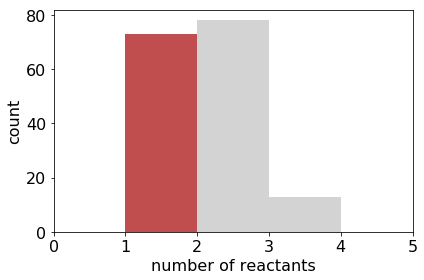

In [50]:
print(len(target_RS_3), 'reactions in threshold')
fig, ax = plt.subplots()    
ax.hist(no_react_1, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(0, 10, 1))
ax.hist(no_react_above,  
        facecolor='lightgray',  # '#FF7900',  
        histtype='stepfilled', bins=np.arange(0, 10, 1))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('number of reactants', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 5)
fig.tight_layout()
fig.savefig(directory+"CS_NoR.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()

## Step 2 (unused):
- From the target RS:
    - Plot the value added as the change in synthetic accessibility
    - Select out reactions with a change in synthetic accessibility $>$ SA threshold

In [60]:
SA_threshold = 1.5

In [61]:
target_RS_2 = []
top_delta_SA = []
other_delta_SA = []
for pkl in target_RS:
    rs = get_RS(directory+pkl, output_dir=directory, verbose=False)
    if abs(rs.delta_sa) > SA_threshold:
        top_delta_SA.append(rs.delta_sa)
        target_RS_2.append(rs.pkl)
    else:
        other_delta_SA.append(rs.delta_sa)

35 reactions in threshold


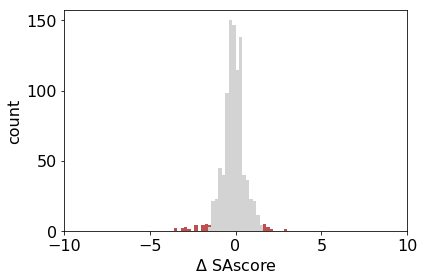

In [62]:
print(len(target_RS_2), 'reactions in threshold')
fig, ax = plt.subplots()    
ax.hist(top_delta_SA, 
        facecolor='firebrick',  # '#1469b5', 
        alpha=0.8, histtype='stepfilled', bins=np.arange(-10, 10, 0.2))
ax.hist(other_delta_SA, 
        facecolor='lightgray',  # '#FF7900', 
        histtype='stepfilled', bins=np.arange(-10, 10, 0.2))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('$\Delta$ SAscore', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(-10, 10)
fig.tight_layout()
fig.savefig(directory+"CS_changeSA.pdf",
            dpi=720,
            bbox_inches='tight')
plt.show()